# Исследование закономерностей, определяющих успешность игры


Интернет-магазине «Стримчик» продаёт компьютерные игры по всему миру. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).


**Цель исследования:** проанализировать данные до 2016 года и выявить закономерности, определяющие успешность игры, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Гипотезы:**
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Ход исследования:**
1. Обзор имеющихся данных
2. Предобработка данных: удаление дубликатов, заполнение пропусков, выявление аномальных значений и их причин, исправление ошибок
3. Исследовательский анализ данных и составление портрета игрока каждого региона
4. Статистический анализ данных и проверка гипотез

### Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('games.csv')
data.head(10) 

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


На первый взгляд датафрейм выглядит адекватно (не нужны дополнительные разделители, серьезные корректировки названий, и т.д.)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


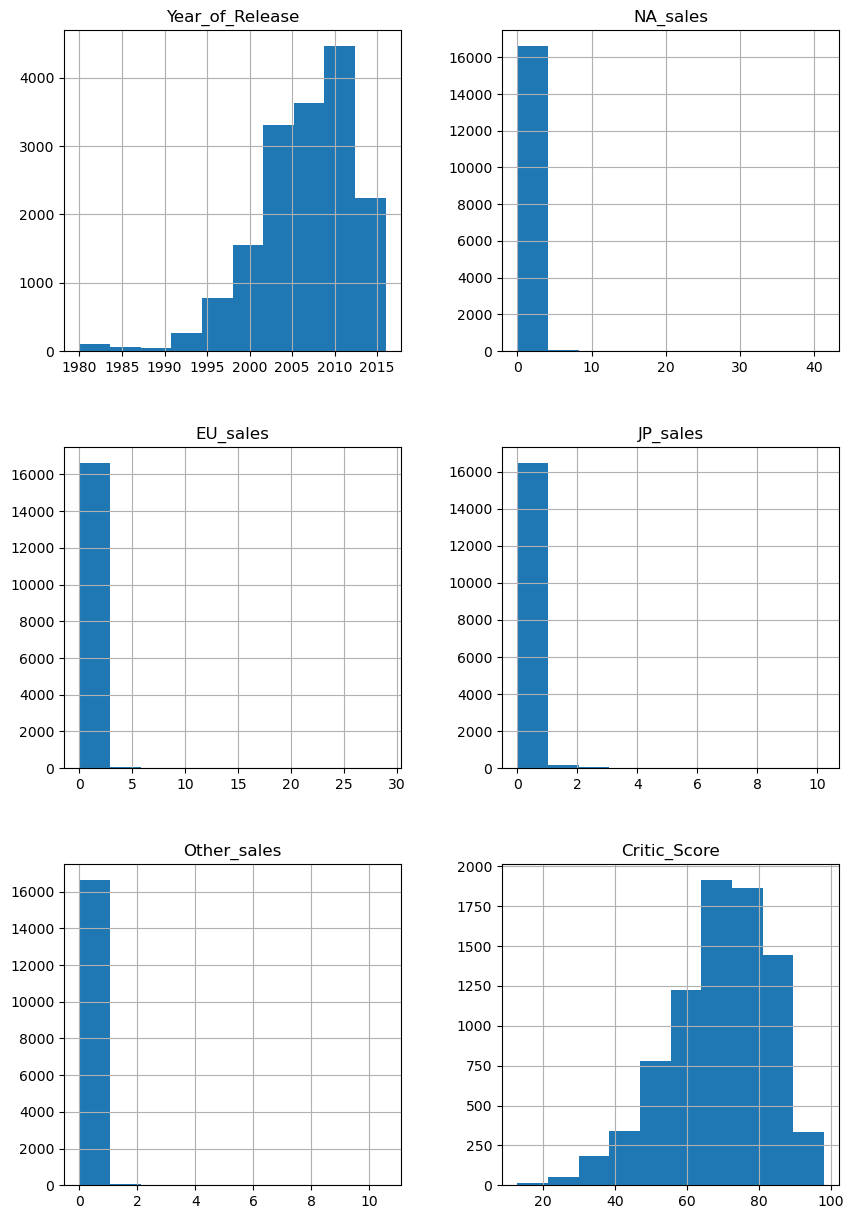

In [3]:
data.info()
data.hist(figsize = (10,15));

#выглядит так, что данные ранее 1998 (или даже 2001) года можно будет отбросить, так как их очень мало

Датафрейм имеет 16715 строк. 
<br>
В некоторых столбцах есть нулевые значения (в "оценочных" и рейтинговом их особенно много).
<br>
Также неверный формат в столбцах year_of_release и user_score, поменяем их после обработки пропусков. 

### Предобработка данных

In [4]:
#столбцы
data.columns
#поправим названия столбцов, чтобы они соответствовали "змеиному" регистру
data.columns = data.columns.str.lower()

#### Проверка дубликатов

In [5]:
#проверим дубликаты
data.duplicated().sum()

0

In [6]:
#проверим названия жанров, чтобы выявить неявные дубликаты
data['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [7]:
#проверим неявные дубликаты в названиях платформ
data['platform'].value_counts()
#самые редкие платформы (1-2 строки) действительно существуют, поэтому убирать и корректировать их не будем

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [8]:
#проверим неявные дубликаты в столбце рейтинга
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Неявные дубликаты отсутствуют. Некоторые повторения есть в названиях игр, но они различаются частями игры, годом выпуска, платформой, поэтому их обрабатывать не будем. 

In [9]:
#проверим дубликаты по паре "название-платформа"
data[data.duplicated(subset = ['name', 'platform'], keep = False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [10]:
#Need for Speed: вышел на PC в 2005 году, на X360 - в 2012
#Sonic и Madden- явные дубликаты

data = data.drop([16230, 1591, 4127, 11715])

#### Обработка пропусков

##### Год выпуска

In [11]:
#обработаем пропуски в данных
data.isna().sum()

#всего два пропуска в столбце name 
#в этих строках отсутствуют данные и в других столбцах, так что просто удаляем их
data[data['name'].isna()==True]
data = data.dropna(subset = ['name'])

#в столбце year_of_release данные могли не заполнить в открытых источниках
#проверим, сможем ли заполнить их по названиям игр
data['name'].value_counts()
#самая часто встречающаяся игра - Need for Speed: Most Wanted
data[data['name']=='Need for Speed: Most Wanted']['year_of_release']
#года у одной и той же игры даже на одинаковых платформах отличаются, поэтому восстанавливать года по названию будет неверно

#заменим вручную года в наиболее часто встречающихся играх (3 и более)
data[data['year_of_release'].isna()]['name'].value_counts()

data.loc[(data['year_of_release'].isna()) & (data['name']=='LEGO Harry Potter: Years 5-7'), 'year_of_release'] = 2011
data.loc[(data['year_of_release'].isna()) & (data['name']=='Rock Band'), 'year_of_release'] = 2007
data.loc[(data['year_of_release'].isna()) & (data['name']=='Happy Feet Two'), 'year_of_release'] = 2011
data.loc[(data['year_of_release'].isna()) & (data['name']=='Bejeweled 3'), 'year_of_release'] = 2010
data.loc[(data['year_of_release'].isna()) & (data['name']=='WRC: FIA World Rally Championship'), 'year_of_release'] = 2010
data.loc[(data['year_of_release'].isna()) & (data['name']=='Test Drive Unlimited 2'), 'year_of_release'] = 2011

In [12]:
#добавим года в тех строках, где в самом названии есть год
#практика показала, что год выпуска часто на один меньше, чем указан в названии

#сначала для 2000-2009 годов
name_with_year_200 = data.loc[(data['name'].str.contains('200')) & (data['year_of_release'].isna())]['name']
name_with_year_200

for name in name_with_year_200:
    i = str(name)
    i.find('200') #находим место, где начинается номер года
    year = int(i[i.find('200'):i.find('200')+4]) -1 #берем срез от начала номера года + 4 цифры и вычитаем один год
    data.loc[(data['name']==name) & (data['year_of_release'].isna()), 'year_of_release'] = year
    
#повторим для годов 2010-2016
#это разделение нужно, чтобы избежать названий, где просто есть число 20, и это не связано с годом
name_with_year_201 = data.loc[(data['name'].str.contains('201')) & (data['year_of_release'].isna())]['name']

for name in name_with_year_201:
    i = str(name)
    i.find('201')
    year = int(i[i.find('201'):i.find('201')+4]) -1
    data.loc[(data['name']==name) & (data['year_of_release'].isna()), 'year_of_release'] = year


data[data['year_of_release'].isna()]['name'].unique()
data.isna().sum()

name                  0
platform              0
year_of_release     227
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Пропуски года часто бывают в играх, которые имеют несколько частей, а также не очень популярные игры, которые выходили давно. хотя есть и исключения (например, Call of Duty 3, World of Tanks, Silent Hill)
Так как год игры для нас очень важен в дальнейших исследованиях, а оставшихся пропусков не так много (227 строк), уберем их. 

In [13]:
data = data.dropna(subset = ['year_of_release'])

##### Оценки игры

Пропуски в данных с оценками скорее всего связаны с некорректным методом сбора данных: использовались определенные сайты, где не всегда была указана полная информация. Такой вывод можно сделать потому, что пропущенных значений в этих столбцах очень много - практически половина. 

Помимо этого отсутствие оценок, также, как и в случае с годом выпуска, можно объяснить непопулярностью игры и отсутствием активности пользователей и критиков. Еще одной причиной может быть давность выхода игры: оценки могли не сохраниться на старых сайтах, например. 

In [14]:
#в колонке с оценками критиков оставим пустующие значения

#посмотрим на пропуски в столбце пользовательских оценок
data['user_score'].unique()
#tbd - to be determined, то есть оценка будет определена позже.
#эти значения пропущены намеренно, поэтому мы заменим их на NaN и будем работать также, как с обычными пропусками
data[data['user_score']=='tbd'][['name','year_of_release']].value_counts()
data.loc[data['user_score']=='tbd', 'user_score'] = np.nan

#оценки пользователей также оставим пустыми

##### Рейтинг

Рейтинг точно должен быть проставлен у всех игр при выходе, поэтому пропуски в этом столбце (особенно учитывая, что их также очень много) объясняются неверным выбором метода сбора информации. 

P.S. если бы пропусков было значительно больше или меньше - можно было бы списать все на техническую ошибку. Но в этом случае, скорее всего, просто использовались неподходящие источники. 

In [15]:
data['rating'] = data['rating'].fillna('Without rating')

Чтобы не искажать данные, оставим пропуски в этих строках, только выделим в отдельную категорию "Без рейтинга"

#### Изменение типов данных

Будем менять типы данных в следующих столбцах:
* year_of_release - так как год может быть только целым числом
* user_score - оценки пользователей, как и критиков должны быть числом

In [16]:
data['user_score'] = pd.to_numeric(data['user_score'])
data['year_of_release'] = data['year_of_release'].astype('int')

#### Финальный обзор

In [17]:
#проверяем финально
data.describe()

#обновим индексы, чтобы не путаться
data = data.reset_index(drop=True)

#приведем пользовательские оценки к тем же единицам измерения, что и оценки критиков
data['user_score'] = data['user_score']*10

#добавим столбец с суммарными продажами
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16482 entries, 0 to 16481
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16482 non-null  object 
 1   platform         16482 non-null  object 
 2   year_of_release  16482 non-null  int32  
 3   genre            16482 non-null  object 
 4   na_sales         16482 non-null  float64
 5   eu_sales         16482 non-null  float64
 6   jp_sales         16482 non-null  float64
 7   other_sales      16482 non-null  float64
 8   critic_score     8011 non-null   float64
 9   user_score       7486 non-null   float64
 10  rating           16482 non-null  object 
 11  total_sales      16482 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB


Итого на этапе предобработки:
* проведена проверка и обработка дубликатов
* заполнены те пропуски, которые было возможно восстановить из имеющихся данных,оставшиеся не будем учитывать в дальнейшем анализе
* удалено строк: 233, это 1,3% данных
* добавлен столбец с суммарными продажами

Данные стали чище, и теперь мы можем приступить к их анализу. 

### Исследовательский анализ данных

#### Общий анализ

Посмотрим, сколько игр выпускалось в разные годы

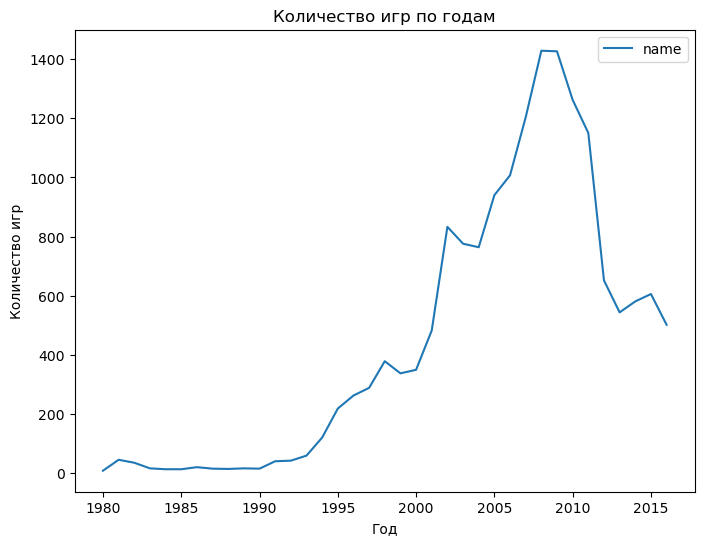

In [62]:
data.groupby('year_of_release')['name'].count()

#представим более наглядно
data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').plot(figsize = (8,6))
plt.title('Количество игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр');

Основные пункты:
* Данных за **1980-1993** год очень мало, индустрия только начинает развиваться, поэтому их можно будет не учитывать в дальнешем анализе
* Больше всего игр было выпущено в период **с 2005 по 2011 год**, самый пик - **в 2008 году**
* **После 2011 года** наблюдается резкий спад (почти в два раза)


<div class="alert-success">
<b>Комментарий ревьюера ✔️</b>

Верно, до 1994-95 года игр выпускалось крайне мало, этот период можно дальше не учитывать. Для наглядности можно увеличить размер графика параметром `figsize`. </div>

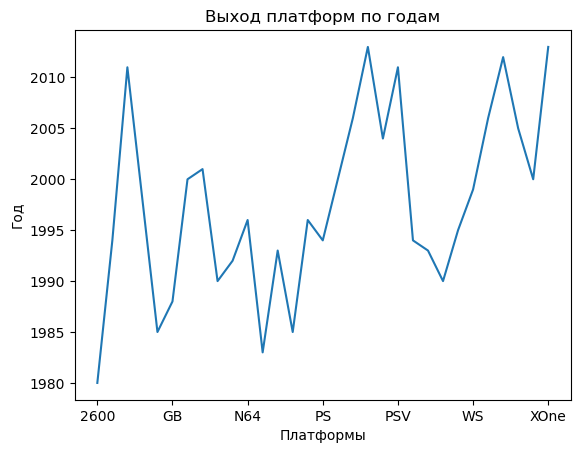

In [79]:
#проверим, как часто выпускались новые платформы
data.groupby('platform')['year_of_release'].min().plot()
plt.title('Выход платформ по годам')
plt.xlabel('Платформы')
plt.ylabel('Год');

#возьмем топ-10 самых дорогих платформ
popular_platforms = (data.groupby('platform')['total_sales'].sum().sort_values(ascending = False)[0:10].index)

[11, 11, 10, 10, 28, 9]


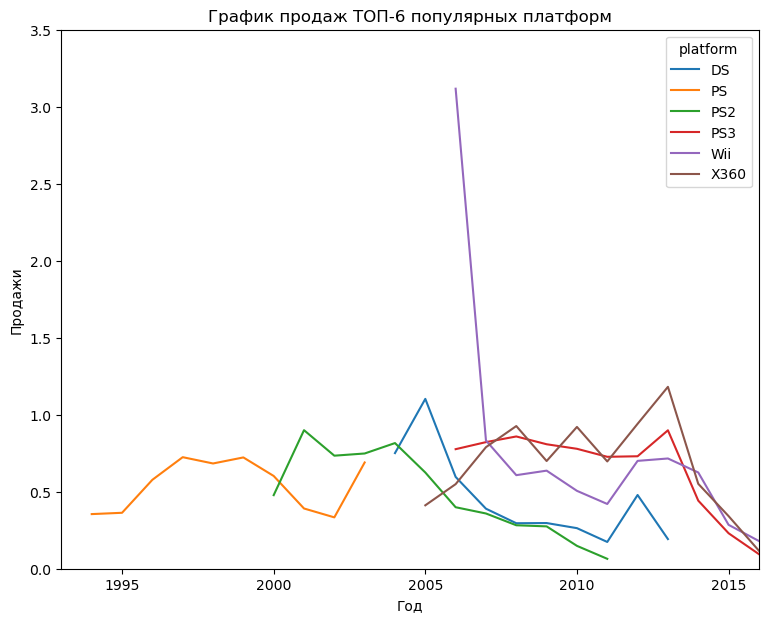

In [68]:
#посмотрим, как зависят продажи от платформы
data.groupby('platform')['total_sales'].sum().sort_values(ascending = False)

#возьмем 6 самых продаваемых платформ  
top_6_platform = data.query('platform == ["PS2","X360","PS3", "Wii", "DS", "PS"]')
top_6_platform.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales').plot(figsize = (9,7))
plt.axis([1993, 2016, 0, 3.5])
plt.title('График продаж ТОП-6 популярных платформ')
plt.xlabel('Год')
plt.ylabel('Продажи');

#посмотрим на длительность "жизни" топ-6 платформ
platform_life = []
for platform in ["PS2","X360","PS3", "Wii", "DS", "PS"]:
    max = data.loc[data['platform']==platform, 'year_of_release'].max()
    min = data.loc[data['platform']==platform, 'year_of_release'].min()
    platform_life.append(max - min)
print(platform_life)

#одно выбивающееся значение - платформа DS с 28 годами жизни, проверим
data.loc[(data['platform']=='DS')&(data['year_of_release']==1985)]
#такая строка только одна, и выглядит, как ошибка
#если верить открытым источникам, платформа DS начала существовать только в 2004 году
#удалим эту строку
data = data.drop([15742])
data = data.reset_index(drop=True)

In [21]:
#проведем цикл еще раз, чтобы обновить данные по платформе DS
platform_life = []
for platform in ["PS2","X360","PS3", "Wii", "DS", "PS"]:
    max = data.loc[data['platform']==platform, 'year_of_release'].max()
    min = data.loc[data['platform']==platform, 'year_of_release'].min()
    platform_life.append(max - min)

platform_life

[11, 11, 10, 10, 28, 9]

In [80]:
#посчитаем средний "возраст" платформ
platform_age = []
for platform in data['platform'].unique():
    max = data.loc[data['platform']==platform, 'year_of_release'].max()
    min = data.loc[data['platform']==platform, 'year_of_release'].min()
    platform_age.append(max - min)

round(sum(platform_age)/len(platform_age),2)

7.61

Основные выводы в этой части: 
* **ТОП-6** самых продаваемых платформ: **PS2, X360, PS3, Wii, DS, PS**
* Интересно, что в период **с 2007 до 2011 года** (а это был пик выпуска новых игр) совсем не появлялось новых платформ
* На общем графике заметно, что основная часть продаж от платформ упала уже **после 2000 года**. Это может быть связано с развитием компьютерных и мобильных игр
* Средняя "продолжительность жизни" одной платформы - **7-8 лет**

Исходя из этих выводов будет логичным в дальнейшем рассматривать период с 2012 по 2016 год, так как индустрия очень динамичная.

In [23]:
df = data.query('year_of_release >=2012')
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,1311.000000,1530.000000,2885.000000
mean,2013.917504,0.204863,0.175737,0.066752,0.054135,72.253242,66.368627,0.501487
std,1.411559,0.566775,0.505422,0.241614,0.164663,12.691282,15.692768,1.249319
min,2012.000000,0.000000,0.000000,0.000000,0.000000,13.000000,2.000000,0.010000
25%,2013.000000,0.000000,0.000000,0.000000,0.000000,66.000000,58.000000,0.040000
50%,2014.000000,0.030000,0.030000,0.010000,0.010000,74.000000,70.000000,0.120000
75%,2015.000000,0.170000,0.140000,0.050000,0.040000,81.000000,78.000000,0.430000
max,2016.000000,9.660000,9.090000,4.390000,3.960000,97.000000,93.000000,21.050000


#### Анализ данных за 2012 - 2016 года


##### Прибыльность платформ

Проверим, какие платформы являются самыми прибыльными за последний год

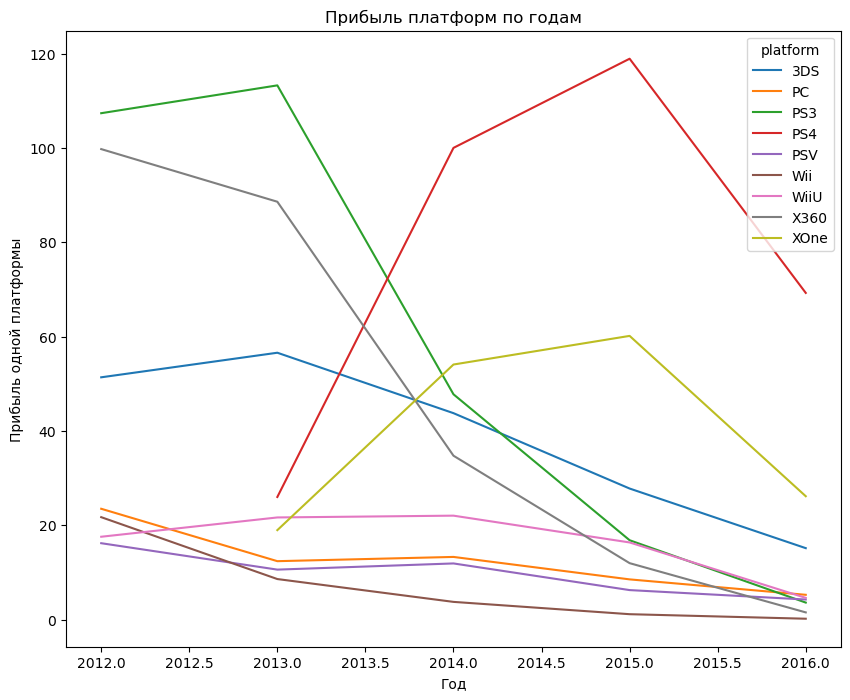

In [81]:
#для начала определим список "живых" платформ
alive_platform = list(df[df['year_of_release']==2016]['platform'].unique())
alive_platform_df = df.query('platform == @alive_platform')

(alive_platform_df
.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
.plot(figsize = (10,8)))
plt.title('Прибыль платформ по годам')
plt.xlabel('Год')
plt.ylabel('Прибыль одной платформы');

Судя по графику, самыми прибыльными на этот год (2016) являются платформы PS4, XOne и 3DS. 
<br>На данный момент все платформы убывающие, однако это явно связано с неполными данными за 2016 год (по графику видно, что в 2015 году прибыль выше). Поэтому сформируем ТОП самых прибыльных платформ по данным за 2015 и 2016 года. 

In [25]:
print((alive_platform_df[alive_platform_df['year_of_release']==2015]
.groupby('platform')['total_sales'].sum().sort_values(ascending = False)
 +
 alive_platform_df[alive_platform_df['year_of_release']==2016]
.groupby('platform')['total_sales'].sum().sort_values(ascending = False)).sort_values(ascending = False)
)

top_sales_platform = ['PS4', 'XOne', '3DS']

platform
PS4     188.15
XOne     86.29
3DS      42.92
WiiU     20.95
PS3      20.42
PC       13.77
X360     13.48
PSV      10.50
Wii       1.32
Name: total_sales, dtype: float64


Скорее всего, делать ставку на "умирающие" платформы (10-11 лет) уже нет смысла, как и на слишком "молодые" (1-2 года). Проверим "возраст" текущих платформ.

In [26]:
#посмотрим,сколько уже лет существуют текущие платформы
df_platform_life = []
for platform in alive_platform:
    max = df.loc[df['platform']==platform, 'year_of_release'].max()
    min = df.loc[df['platform']==platform, 'year_of_release'].min()
    df_platform_life.append(max - min)

print('Возраст "живых" платформ:',df_platform_life)

Возраст "живых" платформ: [3, 4, 3, 4, 4, 4, 4, 4, 4]


Длительность всех платформ с 2012 года оптимальная - 3-4 года. 

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
count,396.000000,250.000000,492.000000,392.000000,411.000000,54.000000,147.000000,292.000000,247.000000
mean,0.491439,0.251680,0.586951,0.801378,0.119659,0.655000,0.559116,0.810068,0.645020
std,1.387161,0.494561,1.464113,1.609456,0.203011,1.165447,1.058836,1.712069,1.036139
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.040000,0.030000,0.050000,0.060000,0.020000,0.062500,0.080000,0.100000,0.060000
50%,0.110000,0.080000,0.200000,0.200000,0.050000,0.180000,0.220000,0.310000,0.220000
75%,0.312500,0.240000,0.610000,0.730000,0.120000,0.687500,0.525000,0.870000,0.685000
max,14.600000,5.140000,21.050000,14.630000,1.960000,6.760000,7.090000,16.270000,7.390000


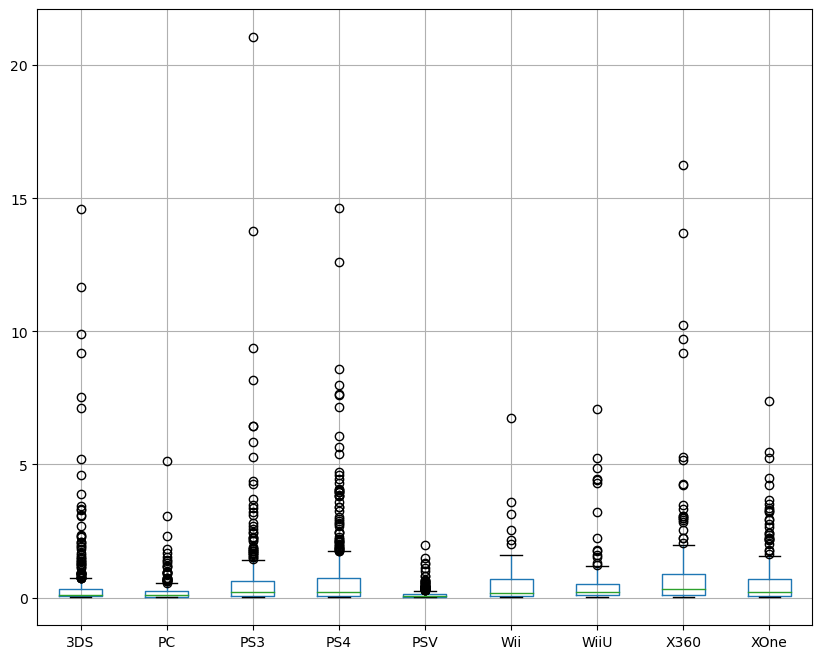

In [83]:
#построим "ящики с усами", чтобы посмотреть на размах прибыли
(alive_platform_df
.pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
.boxplot(figsize = (10,8)));

(alive_platform_df
.pivot_table(index = 'name',columns = 'platform', values = 'total_sales', aggfunc = 'sum')
.describe())

У всех платформ есть достаточно много выбросов: возможно, это самые популярные игры, у которых были большие продажи. 

Платформы, на которых наиболее часто выпускались игры: PS3, PSV, 3DS, PS4. 

У всех платформ медиана сильно выше среднего, следовательно, гораздо больше "дешевых" игр, однако стоит учесть большое количество выбросов. 

Самыми прибыльными выглядят **X360, PS4, Wii и XOne**, их третьи квартили находятся выше всех, а значит, выпуск популярных игр достаточно стабильный.

PSV, PC имеют совсем мало продаж, для PSV это особенно плохо, потому что эта платформа лидирует по количеству игр. 3DS также имеет низкую стабильную доходность, однако много выбросов до 4 млн, как и у "дорогих" платформ. 

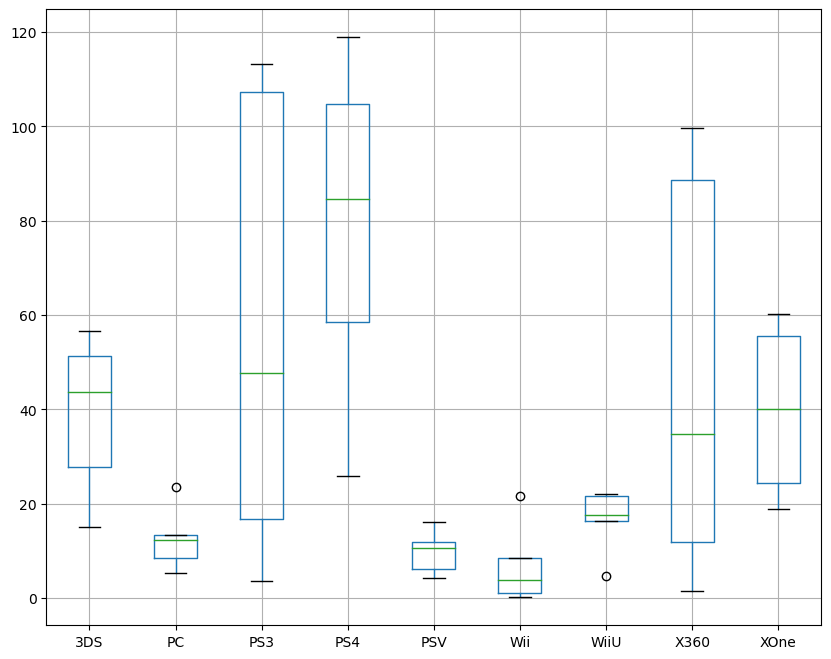

In [84]:
#Код ревьюера
alive_platform_df\
.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')\
.boxplot(figsize = (10,8));

In [29]:
#Код ревьюера 2
alive_platform_df\
.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2012,51.36,23.49,107.35,NaN,16.19,21.71,17.56,99.74,NaN
2013,56.57,12.38,113.25,25.99,10.59,8.59,21.65,88.58,18.96
2014,43.76,13.28,47.76,100.00,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


В целом данные нормально распределены, есть только два выброса: у PC и WiiU. Это может быть ошибкой, либо действительно прибыльным годом для платформы. 

Самыми доходными (суммарно за последние 10 лет) являются **PS3, X360, PS4 и Wii**. 
<br>
Интересно, что PS4 находится в числе самых прибыльных, но при этом существует не так давно, в отличие от других трех. А у Wii среднее значительно выше медианы, что говорит о том, что у платформы есть большое количество "дорогих" игр, которые выбиваются из общего списка. Нужно иметь в виду эти две платформы как потенциально привлекательные. 
У PS3 и X360 ситуация противоположная Wii, плюс они достаточно долго уже существуют на рынке, не будем рассматривать их. 

XOne - медиана и среднее практически равны, выбивающихся значений нет. Существует не очень давно, но уже приносит стабильный доход.
<br>
PC также выглядит в целом стабильным, однако суммарная прибыль слишком маленькая (учитывая, как долго существует эта платформа).
<br>
3DS - среднее ниже медианы, следовательно, в какие-то года выпускались "дешевые" игры (относительно общего списка). 


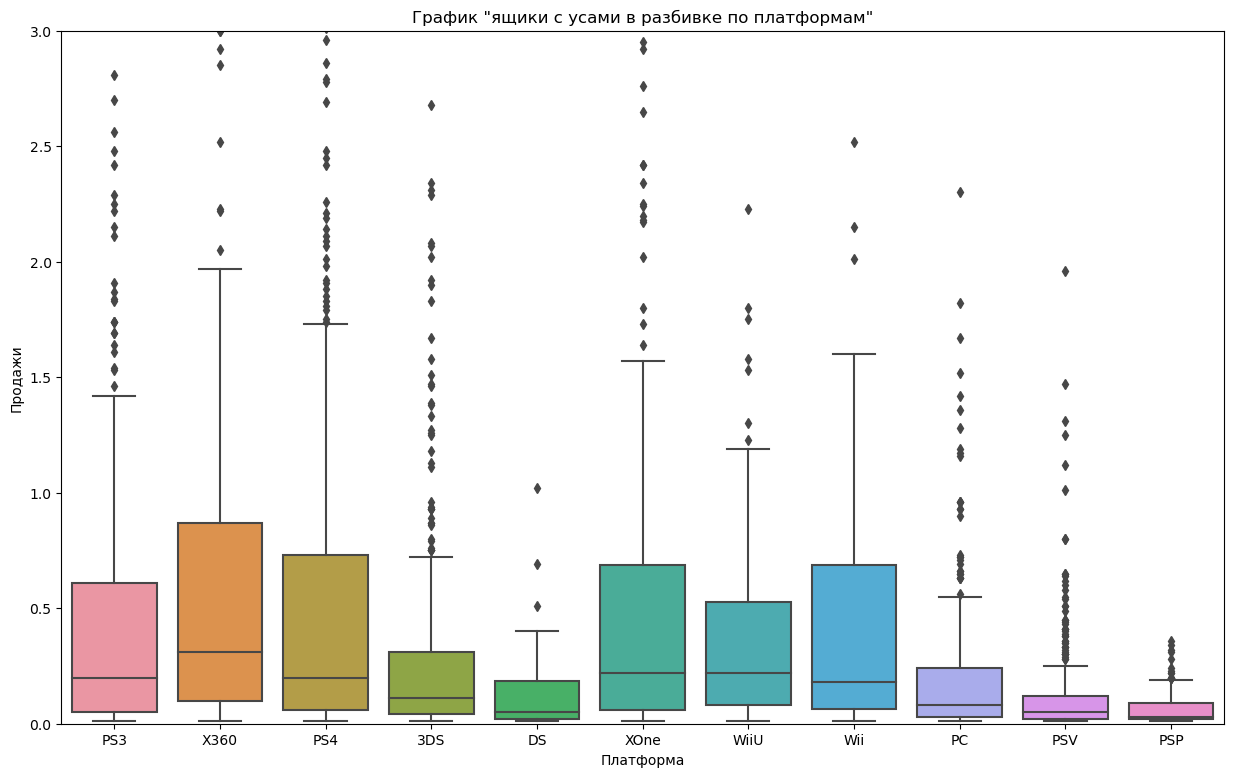

In [85]:
plt.figure(figsize= (15, 9))
sns.boxplot(x = df['platform'], y = df['total_sales'])
plt.title('График "ящики с усами в разбивке по платформам"')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.ylim(0, 3)
plt.show()

In [31]:
top_box_platform = ['PS4', 'Wii', 'XOne', '3DS']

#сформируем ТОП-3 потенциально прибыльных платформы
print('Лучшие по продажам за 2015-2016 гг:',top_sales_platform)
print('Лучшие по продажам за последние 10 лет:', top_box_platform)

final_top_platform = ['PS4', 'XOne', '3DS']
print()
print('Потенциальные платформы:', final_top_platform)

Лучшие по продажам за 2015-2016 гг: ['PS4', 'XOne', '3DS']
Лучшие по продажам за последние 10 лет: ['PS4', 'Wii', 'XOne', '3DS']

Потенциальные платформы: ['PS4', 'XOne', '3DS']


В качестве промежуточного итога анализа я бы предложила использовать в качестве потенциально прибыльных платформ: **PS4, XOne, 3DS**. Они являются самыми прибыльными и за последний год, и за последние 10 лет, а также молодые (не более 5 лет), но при этом уже "раскрученные". 

##### Оценки

Оценим влияние оценок на популярность платформ.
Возьмем для первоначального анализа одну самую популярную платформу - PS4.

,critic_score,total_sales,user_score
critic_score,1.000000,0.406568,0.557654
total_sales,0.406568,1.000000,-0.031957
user_score,0.557654,-0.031957,1.000000


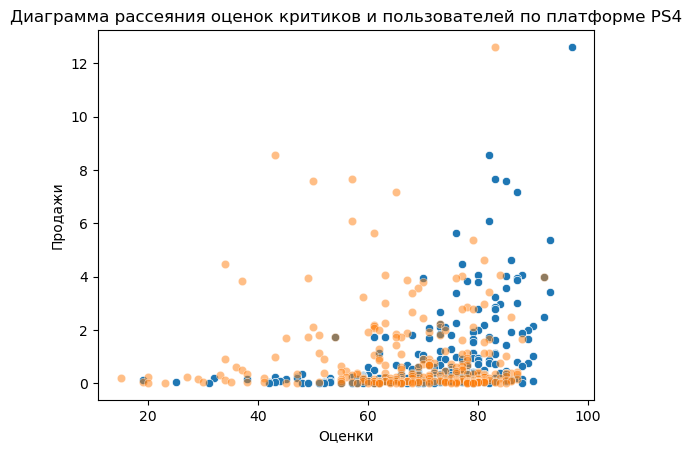

In [86]:
PS4_df = df[df['platform']=='PS4']
sns.scatterplot(data = PS4_df, x = 'critic_score', y = 'total_sales')
sns.scatterplot(data = PS4_df, x = 'user_score', y = 'total_sales', alpha = 0.5).set_xlabel('score')
plt.title('Диаграмма рассеяния оценок критиков и пользователей по платформе PS4')
plt.xlabel('Оценки')
plt.ylabel('Продажи')

PS4_df[['critic_score', 'total_sales', 'user_score']].corr()

**Зависимость** между продажами и оценками критиков прямая и положительная - 0,4. Зависимость от оценки пользователей отрицательная и очень слабая = -0,03 (либо имеет более сложную систему). 
<br>

На графике заметно, что игры с оценками ниже 30 имеют **не более 2 миллионов** проданных копий игр по всему миру. 

Также есть много выбивающихся значений: некоторые игры хорошо продаются, несмотря на средние оценки (40-70), и соответственно, у самых высоких оценок (от 80) - гораздо больше игр с высоким уровнем продаж. 

Интересно, что **низких оценок** (0-20) для этой платформы крайне мало, больше всего - высоких, а **самые высокие оценки** поставлены критиками. 

Вполне логично, что зависимость между оценками пользователей и критиков положительная:**0,55**. 

Максимальный уровень продаж основной массы игр на платформе PS4 - **6 миллионов** проданных копий. 

,critic_score,total_sales,user_score
critic_score,1.000000,0.416998,0.472462
total_sales,0.416998,1.000000,-0.068925
user_score,0.472462,-0.068925,1.000000


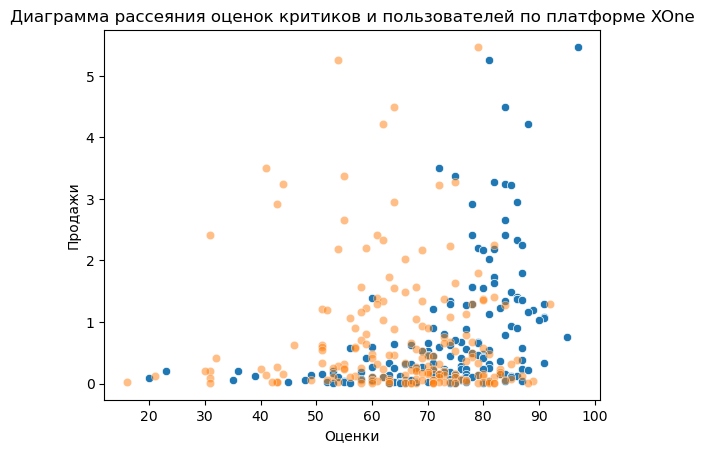

In [87]:
#посмотрим на корреляцию на других платформах
sns.scatterplot(data = df[df['platform']=='XOne'], x = 'critic_score', y = 'total_sales')
sns.scatterplot(data = df[df['platform']=='XOne'], x = 'user_score', y = 'total_sales', alpha = 0.5).set_xlabel('score')
plt.title('Диаграмма рассеяния оценок критиков и пользователей по платформе XOne')
plt.xlabel('Оценки')
plt.ylabel('Продажи')

XOne_df = df[df['platform']=='XOne']

XOne_df[['critic_score', 'total_sales', 'user_score']].corr()

Популярная XOne выглядит примерно также, как и PS4, хотя здесь основной объем продаж снижается до 3 миллионов копий, а количество более низких оценок критиков увеличилось.

,critic_score,total_sales,user_score
critic_score,1.000000,0.320803,0.722762
total_sales,0.320803,1.000000,0.197583
user_score,0.722762,0.197583,1.000000


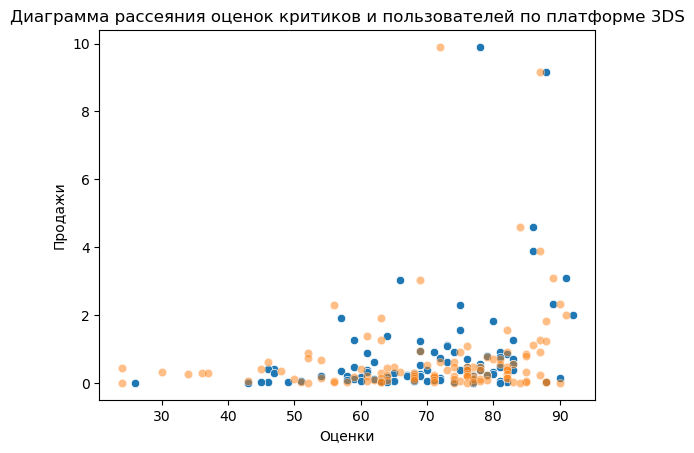

In [88]:
sns.scatterplot(data = df[df['platform']=='3DS'], x = 'critic_score', y = 'total_sales')
sns.scatterplot(data = df[df['platform']=='3DS'], x = 'user_score', y = 'total_sales', alpha = 0.5).set_xlabel('score')
plt.title('Диаграмма рассеяния оценок критиков и пользователей по платформе 3DS')
plt.xlabel('Оценки')
plt.ylabel('Продажи')

DS3_df = df[df['platform']=='3DS']
DS3_df[['critic_score', 'total_sales', 'user_score']].corr()

Продажи 3DS ниже по сравнению с первыми двумя платформами (основная масса - до 2 млн). Здесь, наоборот, оценки пользователей чаще бывают выше, чем оценки критиков. 

Здесь уже корреляция между оценками критиков и продажами  снижается до 0,3, а пользовательские оценки, наоборот, становятся выше - 0,2. Хотя и наблюдается несколько выбросов с высокими оценками. 

По итогам рассмотрения **уровня продаж в зависимости от оценок** пользователей и критиков, можно сделать следующие выводы: 
* **Корреляция** между оценками критиков и продажами средняя положительная. Зависимость от пользовательских оценок более сложная: на разных платформах проявлялась по разному, значит, имеет более сложную структуру. 
* Оценки критиков и пользователей в большинстве случаев **совпадают**, хотя чаще оценки критиков все же **чуть выше**, а совсем низкие практически отсутствуют. Скорее всего это связано с тем, что у критиков есть четкие критерии и параметры оценки игр, а пользователи могут ориентироваться на личные предпочтения и эмоции. 

##### Жанры

In [36]:
df['genre'].value_counts()

Action          1032
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Misc             192
Racing           114
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

Самые выпускаемые жанры: Action, Role-Playing, Adventure, Sports и Shooter. 

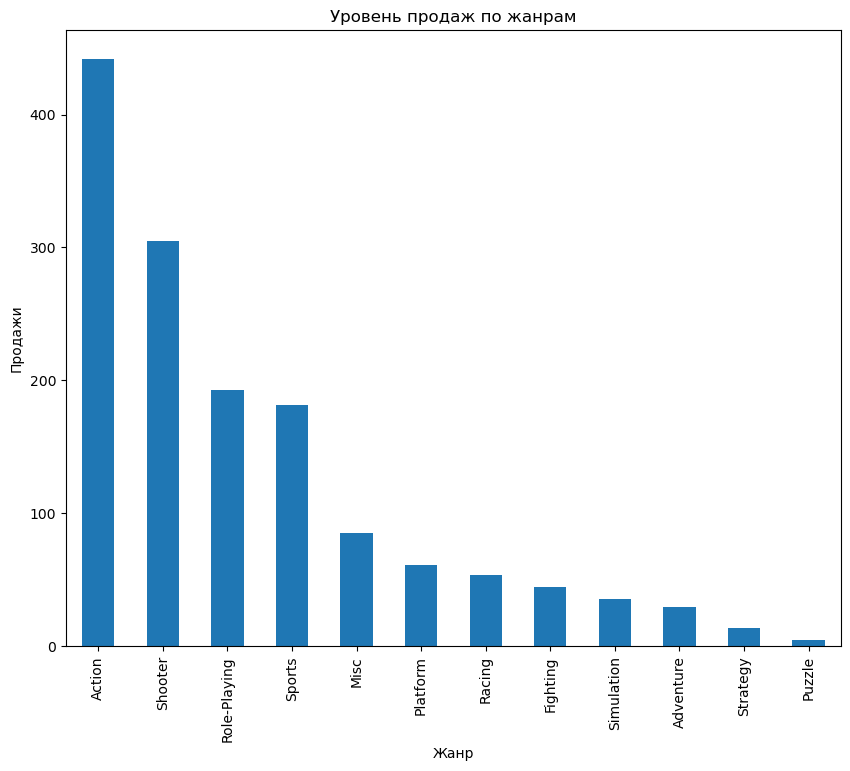

In [89]:
df.groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot(figsize = (10,8), kind = 'bar')
plt.title('Уровень продаж по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи');

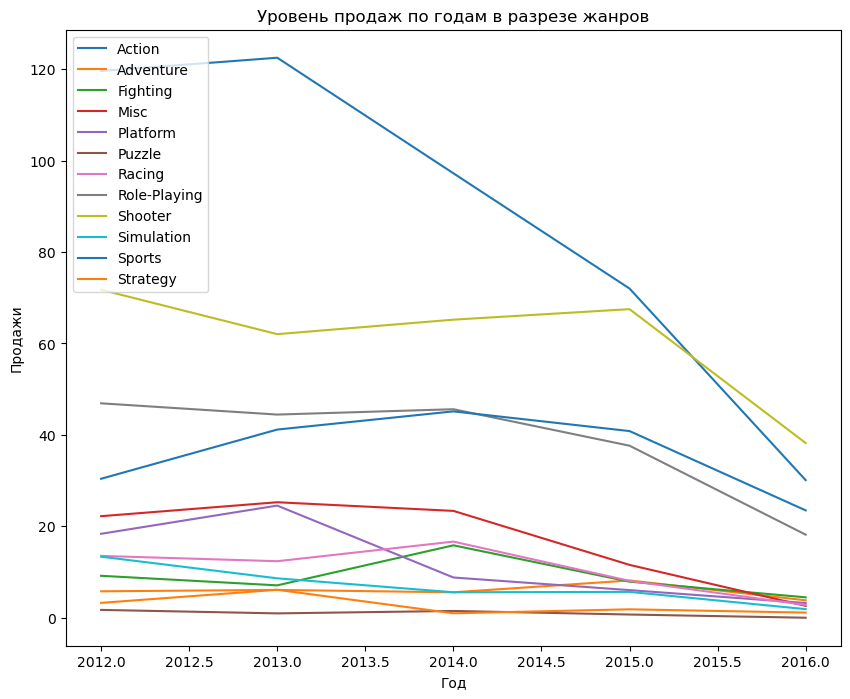

In [90]:
(df
.pivot_table(index = 'year_of_release', columns = 'genre', values = 'total_sales', aggfunc = 'sum')
.plot(figsize = (10,8)).legend(loc = 'upper left'))
plt.title('Уровень продаж по годам в разрезе жанров')
plt.xlabel('Год')
plt.ylabel('Продажи');

Самые прибыльные жанры в целом: **Action, Shooter, Role-Playing и Sports**.

Однако если делать разбивку по годам, можно заметить, что за последний год популярность Action стала ниже, чем Shooter, а продажи Role-Playing опустились ниже, чем у Sports. 

In [39]:
#рассмотрим средние и медианные продажи для каждого жанра
data.groupby('genre')['total_sales'].median().sort_values(ascending = False)

genre
Platform        0.27
Shooter         0.24
Sports          0.22
Fighting        0.21
Action          0.19
Racing          0.19
Role-Playing    0.18
Misc            0.16
Simulation      0.15
Puzzle          0.11
Strategy        0.10
Adventure       0.05
Name: total_sales, dtype: float64

In [40]:
data.groupby('genre')['total_sales'].mean().sort_values(ascending = False)

genre
Platform        0.940262
Shooter         0.803519
Role-Playing    0.628683
Racing          0.588701
Sports          0.570281
Fighting        0.531814
Action          0.518804
Misc            0.462371
Simulation      0.452695
Puzzle          0.420472
Strategy        0.256419
Adventure       0.180456
Name: total_sales, dtype: float64

Самые высокие медианы (то есть стабильный высокий доход) у жанров Platform, Shooter, Sports, Fighting, Action. 
<br>Самые высокие средние значения у жанров: Platform, Shooter, Role-Playing, Racing, Sports. 

Средние у жанров гораздо выше, чем медианы, значит, часто бывают выбросы в виде очень прибыльных игр. 

In [41]:
#возьмем в качестве ТОП-3 жанров те, у которых стабильно высокие продажи
#но также бывают и выбросы в большую сторону
top_genres = ['Platform', 'Sports', 'Shooter']

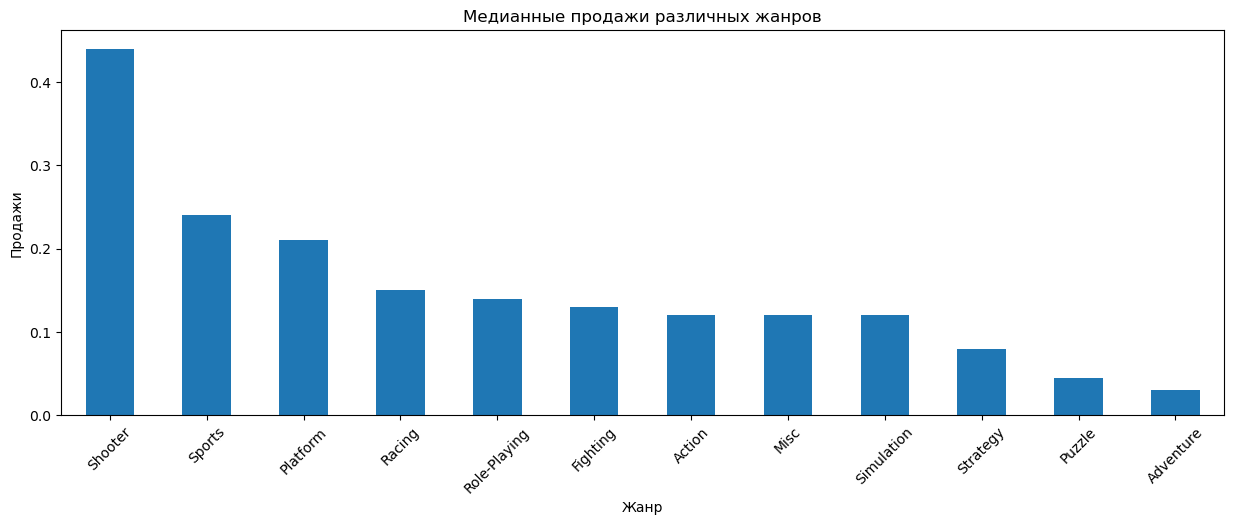

In [157]:
#Код ревьюера
df.groupby('genre')['total_sales'].median()\
    .sort_values(ascending = False)\
    .plot(kind = 'bar', figsize = (15,5), title = 'Медианные продажи различных жанров')
plt.xticks(rotation = 45)
plt.xlabel('Жанр')
plt.ylabel('Продажи');

### Портрет пользователя каждого региона

In [43]:
#сравним продажи в разных регионах
print('Продажи в Северной Америке:',df['na_sales'].sum().round())
print('Продажи в Европе:',df['eu_sales'].sum().round())
print('Продажи в Японии:',df['jp_sales'].sum().round())
print('Продажи в других регионах:',df['other_sales'].sum().round())

Продажи в Северной Америке: 591.0
Продажи в Европе: 507.0
Продажи в Японии: 193.0
Продажи в других регионах: 156.0


Сначала посмотрим на портрет каждого региона отдельно в цифрах, потом сравним их на графиках.

#### Северная Америка

In [44]:
alive_platform_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[0:5]

platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

In [45]:
df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[0:5]

genre
Action          177.90
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

ТОП-5 самых продаваемых платформ Северной Америки: **X360, PS4, PS3, XOne, 3DS**. 

ТОП-5 самых продаваемых жанров Северной Америки: **Action, Shooter, Sports, Role-Playing, Misc**

#### Европа

In [46]:
alive_platform_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[0:5]

platform
PS4     141.09
PS3     106.85
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64

In [47]:
df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[0:5]

genre
Action          159.59
Shooter         113.47
Sports           69.08
Role-Playing     48.53
Racing           27.23
Name: eu_sales, dtype: float64

ТОП-5 самых популярных платформ в Европе: **PS4, PS3, X360, XOne, 3DS**. 

ТОП-5 самых продаваемых жанров в Европе: **Action, Shooter, Sports, Role-Playing, Racing.** 

#### Япония

In [48]:
alive_platform_df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[0:5]

platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64

In [49]:
df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[0:5]

genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64

ТОП-5 самых популярных платформ в Японии:**3DS, PS3, PSV, PS4, WiiU**
<br> Тут все выглядит логично, учитывая, что компания Nintendo (3DS) - японский производитель. 

ТОП-5 самых продаваемых жанров в Японии: **Role-Playing, Action, Misc, Simulation, Fighting**. Основных жанра все же два: Role-Playing и Action, другие три сильно отстают. 

#### Сравнение регионов

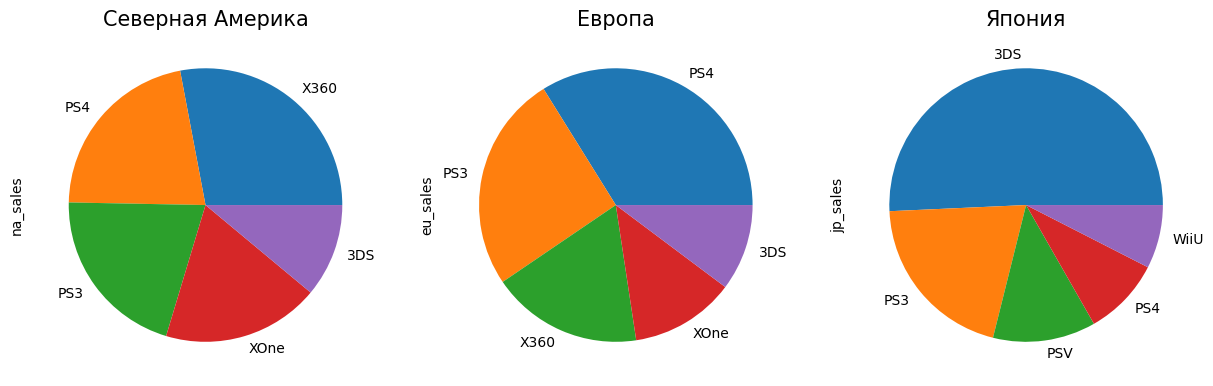

In [127]:
plt.subplot(131)
alive_platform_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[0:5]\
.plot(kind = 'pie', figsize = (15,15))
plt.title('Северная Америка', fontsize = 15)

plt.subplot(132)
alive_platform_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[0:5].plot(kind = 'pie')
plt.title('Европа', fontsize = 15)

plt.subplot(133)
alive_platform_df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[0:5].plot(kind = 'pie')
plt.title('Япония', fontsize = 15);


In [51]:
print(final_top_platform)

['PS4', 'XOne', '3DS']


Популярные платформы в Северной Америке и Европе совпадают, только оказываются в разных пропорциях. 
<br>В Японии же самой популярной платформой остается 3DS от собственного производителя. Однако также есть пересечения с первыми двумя регионами: PS3, PS4.

Итого, чтобы иметь прибыль, эффективнее всего будет разработать игру на разных платформах для разных регионов: **X360** для Америки, **PS4** для Европы и **3DS** для Японии. 

Если же необходимо выбрать только одну, я бы предложила обратить внимание на **PS4**. Она присутствует в ТОПах всех рассмотренных регионов, а также находится в списке лучших платформ по даннным нашего анализа (на основании давности существования и прибыльности).

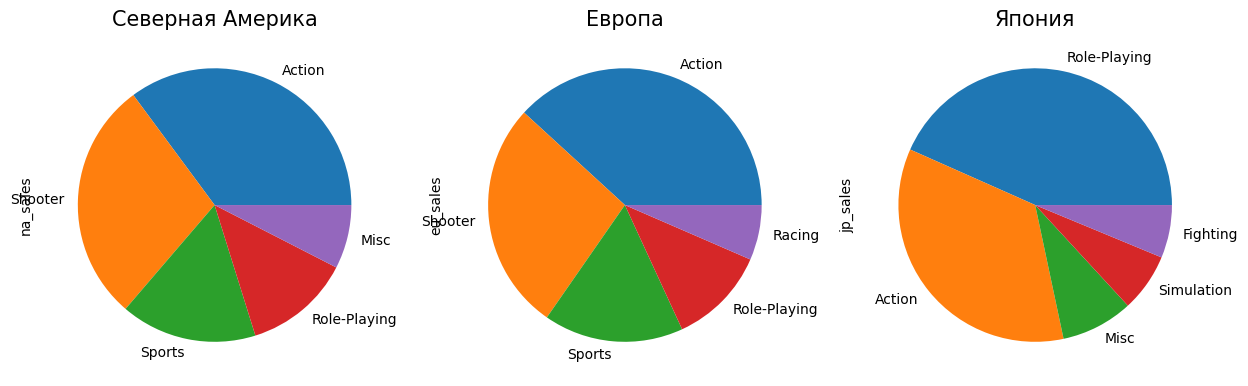

In [156]:
plt.subplot(131)
df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[0:5].plot(kind = 'pie', figsize = (15,15))
plt.title('Северная Америка', fontsize = 15)

plt.subplot(132)
df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[0:5].plot(kind = 'pie')
plt.title('Европа', fontsize = 15)

plt.subplot(133)
df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[0:5].plot(kind = 'pie')
plt.title('Япония', fontsize = 15);

Как и с платформами, выбор жанров в Америке и Европе очень похож (4 совпадения из 5 как по самому жанру, так и по его доле), Япония же имеет отличия. Это, конечно, связано с тесной связью первых двух регионов, и некоторой отождественностью Японии. Тем не менее, общее есть. 

Самым популярным жанром в Америке и Европе (и чуть менее - в Японии) является **Action**, на второе место можно поставить **Role-Playing**, который также присутствует в ТОПах всех стран. 

#### Влияние рейтинга на продажи

Расшифровка рейтингов ESRB:
* E» («Everyone») — «Для всех»
* «EC» («Early childhood») — «Для детей младшего возраста»: от 3 лет
* «E10+» («Everyone 10 and older») — «Для всех старше 10 лет»
* «T» («Teen») — «Подросткам 13—19 лет»
* «M» («Mature») — «От 17 лет»
* «AO» («Adults Only 18+») — «Только для взрослых»
* «RP» ( «Rating Pending»») — «Рейтинг ожидается»

In [53]:
#посмотрим, как влияет рейтинг на продажи
df.pivot_table(index='rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc =['count','sum'])

count                        sum                  
               eu_sales jp_sales na_sales eu_sales jp_sales na_sales
rating                                                              
E                   394      394      394   113.02    28.33   114.37
E10+                306      306      306    55.37     8.19    75.70
M                   499      499      499   194.21    21.20   231.63
T                   411      411      411    52.90    26.02    66.02
Without rating     1275     1275     1275    91.50   108.84   103.31

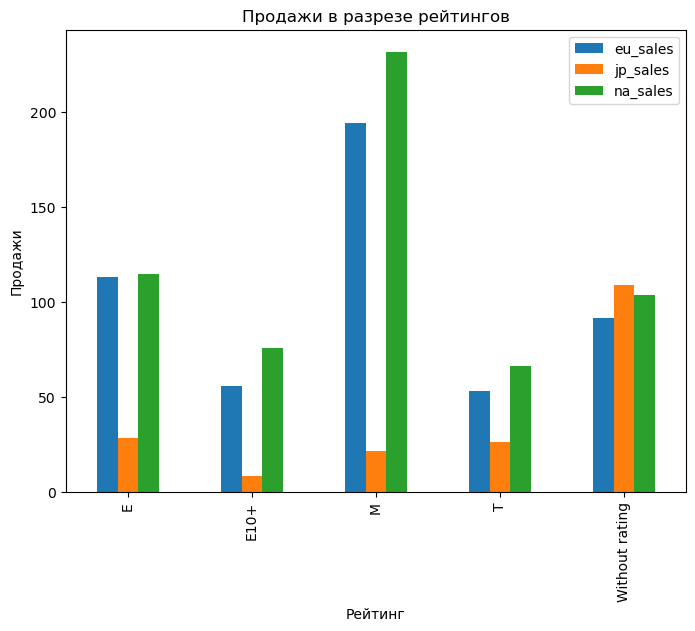

In [158]:
df.pivot_table(index='rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc ='sum')\
.plot(kind = 'bar', figsize = (8,6))
plt.title('Продажи в разрезе рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи');

Самые "популярные" рейтинги в Америке  и Европе: **'M', 'E'**: игр для подростков и детей гораздо меньше, чем универсальных, подходящей всем и людям старше 17. Вероятно, это связано с сильным развитием игровой индустрии этих регионах. 

Самые частые рейтинги в Японии: **"E", "T"**: чаще продаются игры для всех и для подростков.

Топ по количеству выпущенных игр: 'M', 'T'. Игры для подростков и молодых людей все же выпускаются чаще всего. 

**ИТОГИ** по сравнению регионов. Посмотрим на "идеальную" игру для каждого из них: 
* Северная Америка: Action на платформе X360 с рейтингом "M"
* Европа: Action на платформе PS4 с рейтингом "M"
* Япония: Role-Playing на платформе 3DS с рейтингом "E"

Если же попытаться объединить их все в одну игру, она будет выглядеть так: 
**Action на платформе PS4 с рейтингом "E"**

Однако если между Америка и Европа достаточно похожи в своих предпочтениях, то Япония имеет существенные отличия, поэтому для повышения прибыльности необходимо разделять их и предлагать для этих регионов разные варианты игр. 


### Проверка гипотез

Проверим наши гипотезы: 
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

#### Рейтинги платформ Xbox One и PC 

In [55]:
#возьмем данные без пропусков
XOne_user_score = df[df['platform']=='XOne']['user_score'].dropna()
PC_user_score = df[df['platform']=='XOne']['user_score'].dropna()

Нулевая гипотеза H0: XOne_user_score = PC_user_score

Альтернативная двусторонняя гипотеза: XOne_user_score != PC_user_score

In [56]:
alpha = .01

result_1 = st.ttest_ind(XOne_user_score, PC_user_score)
print('p-value:', result_1.pvalue)

if result_1.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Не получилось отвергнуть H0')

p-value: 1.0
Не получилось отвергнуть H0


Гипотезу о равенстве рейтингов платформ XOne_user_score и PC_user_score отвергнуть не удалось. 

#### Рейтинги жанров Action и Sports

In [58]:
Action_user_score = df[df['genre']=='Action']['user_score'].dropna()
Sports_user_score = df[df['genre']=='Sports']['user_score'].dropna()

Нулевая гипотеза H0: Action_user_score = Sports_user_score

Альтернативная двусторонняя гипотеза: Action_user_score != Sports_user_score
<br>Однако тут нужно будет помнить о том, что наша основная гипотеза - что рейтинги разные. 

In [59]:
alpha = .01

results = st.ttest_ind(Action_user_score, Sports_user_score)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Не получилось отвергнуть H0')

p-value: 3.719002625423399e-26
Отвергаем H0


Нулевая гипотеза отвержена, следовательно, рейтинги жанров Action и Sports различны. Основная заявленная гипотеза подтверждена. 

### Общие выводы

В ходе исследования на этапе предобработки данных было обнаружена, что имеется достаточно серьезная проблема со сбором оценок от пользователей и критиков, а также рейтингов: в этих колонках отсутствовала практически половина значений. Некоторые данные получилось восстановить, однако в дальнейшем необходимо пересмотреть систему сбора этих данных, чтобы они были более корректными при анализе. 

Основные выводы, которые были сделаны:
* После 2011 года наблюдается резкий спад выпуска игр, который, вероятно, связан с развитием веб и мобильных игр
* ТОП-6 самых продаваемых платформ за все время: PS2, X360, PS3, Wii, DS, PS
* Средняя "продолжительность жизни" одной платформы - 7-8 лет
* Корреляция между оценками критиков и продажами средняя положительная, взаимовзясь между пользовательскими оценками и продажами обнаружить не удалось. 


Были проверены гипотезы и сделан вывод о том, что обе они верны:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Рекомендации**
<br>
Выделили ТОП-3 платформ, на которые стоит обратить внимание при дальнейшем планировании выпуска игр: **PS4, XOne, 3DS**. Они являются самыми прибыльныии на текущий момент, за последние 10 лет (из существующих), а также достаточно молодыми (от 3 до 5 лет)

Выделили ТОП-5 потенциально прибыльных жанров: **Platform, Sports, Shooter** на основе оценки общей прибыли, динамике за последние годы и стабильности продаж.

Сравнили данные по регионам (Северная Америка, Европа, Япония) и вычислили потенциально "идеальную" игру, которая может быть успешной в каждом из них: **Action на платформе PS4 с рейтингом "E"**. Однако ввиду существенных отличий предпочтений Японии, все же рекомендуется формировать для нее отдельное предложение.